In [ ]:
# Загрузка данных и первичный осмотр
import pandas as pd

df = pd.read_csv('data_ab.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [ ]:
# Проверка структуры датасета
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
count,294478.000000,294478,294478,294478,294478.000000
unique,NaN,294478,2,2,NaN
top,NaN,2025-01-16 12:40:24.467417,treatment,old_page,NaN
freq,NaN,1,147276,147239,NaN
mean,787974.124733,NaN,NaN,NaN,0.119659
std,91210.823776,NaN,NaN,NaN,0.324563
min,630000.000000,NaN,NaN,NaN,0.000000
25%,709032.250000,NaN,NaN,NaN,0.000000
50%,787933.500000,NaN,NaN,NaN,0.000000
75%,866911.750000,NaN,NaN,NaN,0.000000


In [ ]:
# Проверка корректности рандомизации
df['group'].value_counts(normalize=True)
df['converted'].mean()
df.groupby('group')['converted'].mean()
df.groupby('landing_page')['converted'].mean()

,converted
landing_page,
new_page,0.118841
old_page,0.120478


Датасет содержит 77 670 наблюдений, в нём присутствуют две основные группы: old_page и new_page. Распределение по группам практически равное (≈50/50).

Общая конверсия составляет около 12%. Конверсия у old_page немного выше (≈0.12098), чем у new_page (≈0.11997), однако разница очень мала и не позволяет сделать выводы без статистической проверки.

В качестве ключевой метрики A/B-теста выбрана Conversion Rate (CR), отражающая долю пользователей, совершивших целевое действие.

#3. Формулировка нулевой гипотезы

В рамках данного A/B-теста сравниваются две версии страницы: старая версия, показанная пользователям контрольной группы, и новая версия, показанная пользователям тестовой группы. Цель эксперимента — проверить, оказывает ли внедрение новой версии страницы влияние на поведение пользователей.

В качестве ключевой метрики была выбрана Conversion Rate (CR) — доля пользователей, совершивших целевое действие. Переменная converted является бинарной и принимает значения 0 и 1, поэтому среднее значение этой переменной по группе интерпретируется как вероятность конверсии случайно выбранного пользователя из данной группы.

Обозначим через

**𝑝𝐶 - истинную вероятность конверсии пользователя из контрольной группы**

**𝑝𝑇 - истинную вероятность конверсии пользователя из тестовой группы.**



###**Итак получаем:**

###H0: pT=pC - Нулевая гипотеза соответствует отсутствию эффекта: внедрение новой версии страницы не изменяет вероятность конверсии пользователя.

###H1: pT≠pC - Альтернативная гипотеза означает, что внедрение новой версии страницы приводит к изменению вероятности конверсии.

Таким образом, задача A/B-тестирования сводится к статистической проверке гипотезы о равенстве вероятностей конверсии в контрольной и тестовой группах.



#4.Исследование для выбора статистического теста




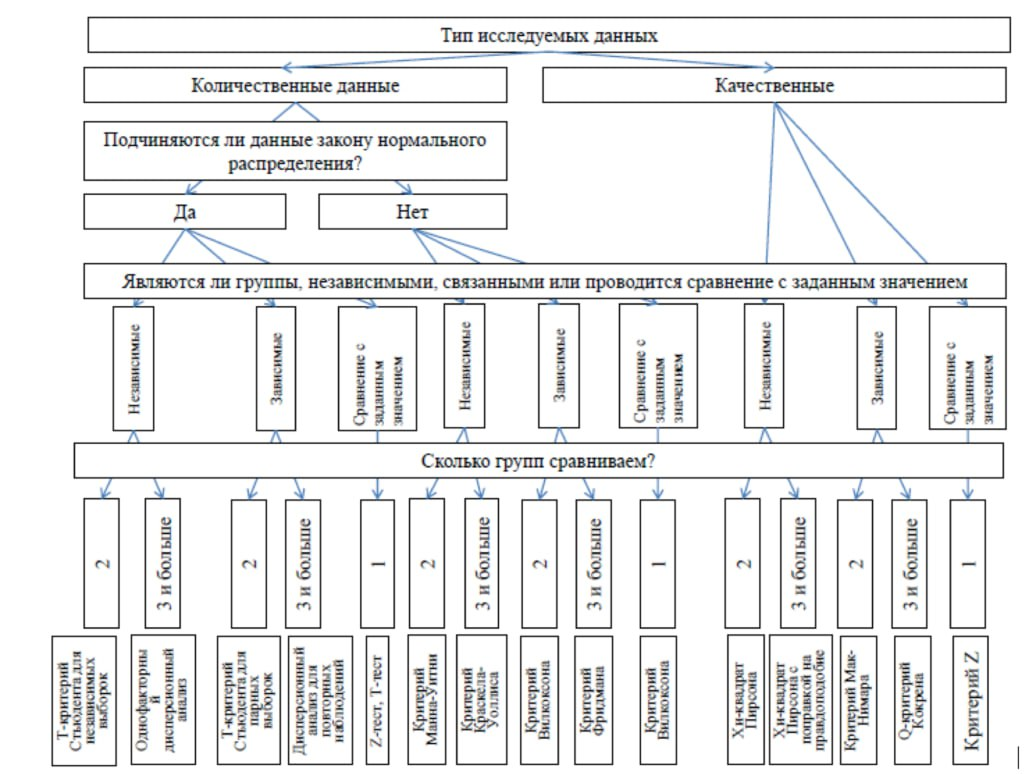

Будем действовать по шагам этой картинки:

####Рассмотрим исследуемую метрику converted.

In [ ]:
df["converted"].unique()


array([0, 1])

Переменная converted принимает только значения 0 и 1, следовательно, она является качественной бинарной переменной, а не количественной.

####Определяем количество сравниваемых групп

In [ ]:
df["group"].value_counts()

,count
group,
treatment,145311
control,145274


В эксперименте участвуют две группы пользователей: контрольная (control) и тестовая (treatment).
Сравниваются две группы.

####Проверяем, являются ли выборки зависимыми или независимыми

Нас интересует попадает ли один пользователь в разные группы.

In [ ]:
user_group_counts = df.groupby("user_id")["group"].nunique()
user_group_counts.value_counts()

,count
group,
1,290584


нет ни одного пользователя, который бы встречался более чем в одной группе. Следовательно, даные независимые

####Выбор статистического теста по схеме

Итак, по результатам предыдущих шагов имеем:

- данные—качественные (бинарные);

- сравниваются две группы;

- группы независимы;

Согласно алгоритму выбора статистического теста для таких условий, допустимым критерием являются:
χ²-тест независимости



Для χ²-теста нам нужна таблица сопряжённости группа × конверсия:

In [ ]:
from scipy.stats import chi2_contingency
ct = pd.crosstab(df["group"], df["converted"])
ct

converted,0,1
group,,
control,127785,17489
treatment,128047,17264


Запускаем χ²-тест независимости:

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(ct)

print("chi2:", chi2)
print("dof:", dof)
print("p-value:", p_value)

chi2: 1.7053502645115002
dof: 1
p-value: 0.19158976298516003


In [ ]:
alpha = 0.05
p_value < alpha

np.False_

Для проверки гипотезы о равенстве конверсий в контрольной и тестовой группах был применён χ²-тест независимости.

В результате теста было получено значение p-value = 0.192, что превышает уровень значимости α = 0.05. Следовательно, нулевая гипотеза не отвергается.

Это означает, что статистически значимых различий в конверсии между контрольной и тестовой группами на уровне значимости 5% обнаружено не было. У нас нет оснований отвергнуть нулевую гипотезу.